# City bikes in Helsinki and Espoo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

### Data  
The city bike data was downloaded from HSL Open Data: [https://www.hsl.fi/en/hsl/open-data](https://www.hsl.fi/en/hsl/open-data)

It contains every journey made with the HSL city bikes in Helsinki and Espoo between 2020 and 2024, with the following information:

- **Departure**: the departure time.  
- **Return**: the return time.  
- **Departure_id**: the ID of the departure station.  
- **Departure_name**: the name of the departure station.  
- **Return_id**: the ID of the return station.  
- **Return_name**: the name of the return station.  
- **Distance**: the total distance of the journey in meters.  
- **Duration**: the total time of the journey in seconds.



#### Loading the data

In [2]:
dtypes = {'Departure_id': str, 'Departure_name': str, 
            'Return_id': str, 'Return_name': str}
bike_df = pd.read_csv('data.csv', dtype=dtypes, parse_dates=['Departure', 'Return'])
bike_df.head()

,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration
0,2020-03-23 06:09:44,2020-03-23 06:16:26,086,Kuusitie,111,Esterinportti,1747.0,401.0
1,2020-03-23 06:11:58,2020-03-23 06:26:31,026,Kamppi (M),010,Kasarmitori,1447.0,869.0
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254,Agnetankuja,1772.0,469.0
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106,Korppaanmäentie,7456.0,2406.0
4,2020-03-23 06:36:09,2020-03-23 07:04:10,062,Välimerenkatu,121,Vilhonvuorenkatu,7120.0,1679.0


In [3]:
station_df = pd.read_csv('locations.csv')
station_df = station_df.set_index('ID')
station_df.index = station_df.index.fillna(-1).astype(int).astype(str).str.zfill(3)  # Add leading zeros to IDs
station_df.head()

,name,lat,lon,capacity,source
ID,,,,,
150,Töölönlahden puisto,60.174646,24.935186,24,HSL
161,Eteläesplanadi,60.167231,24.947466,34,HSL
162,Leppäsuonaukio,60.169573,24.926590,28,HSL
163,Lehtisaarentie,60.181813,24.850440,12,HSL
118,Fleminginkatu,60.188154,24.952916,22,HSL


In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
bike_df.describe()

,Departure,Return,Distance,Duration
count,13595845,13595894,13587435.00,13386674.00
mean,2022-06-05 18:29:32.639168512,2022-06-05 18:52:52.522968576,2376.93,1052.06
min,2020-03-23 06:09:44,2020-03-23 06:16:26,-4294397.00,0.00
25%,2021-04-30 17:10:12,2021-04-30 17:28:45,1092.00,366.00
50%,2022-06-16 17:48:23,2022-06-16 18:04:22,1923.00,631.00
75%,2023-08-11 13:59:53,2023-08-11 14:17:03.750000128,3242.00,1051.00
max,2024-10-31 23:59:57,2024-11-05 11:55:44,3681009.00,6286982.00
std,NaN,NaN,10433.96,11221.56


#### Data exploration and cleaning

The city bike season typically runs from the beginning of April to the end of October. In 2020, the season started unusually early on March 23rd. To maintain consistency across seasons, rides from March 2020 are excluded from the analysis.

In [5]:
bike_df = bike_df[bike_df['Departure'].dt.month != 3]

Check the percentage of missing values for each row

In [6]:
missing_counts = bike_df.isnull().sum()
missing_percent = 100 * missing_counts / len(bike_df)
missing_summary = pd.DataFrame({'count': missing_counts, 'percent': round(missing_percent, 3)})
print(missing_summary)

                 count  percent
Departure           69     0.00
Return              20     0.00
Departure_id         0     0.00
Departure_name       0     0.00
Return_id           79     0.00
Return_name         79     0.00
Distance          8479     0.06
Duration        209240     1.54


#### Missing data summary

The `Duration` column has the most missing values and requires further investigation to decide how to handle the missing values. The other columns have such a small percentage of missing data that removing the rows with missing values will have a negligible impact on the analysis.


##### Exploring the missing Duration values

In [7]:
bike_df[bike_df['Duration'].isna()]

,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration
5782182,2021-10-01 00:01:09,2021-10-01 00:11:49,029,Baana,040,Hakaniemi (M),3055.00,NaN
5782183,2021-10-01 00:01:16,2021-10-01 00:58:59,008,Vanha kirkkopuisto,133,Paavalinpuisto,5883.00,NaN
5782184,2021-10-01 00:01:48,2021-10-01 00:11:19,096,Huopalahdentie,208,Valimotie,2109.00,NaN
5782185,2021-10-01 00:02:38,2021-10-01 00:15:54,019,Rautatientori / itä,058,Lauttasaarensilta,3493.00,NaN
5782186,2021-10-01 00:03:21,2021-10-01 00:21:56,023,Kiasma,142,Koskelantie,4772.00,NaN
...,...,...,...,...,...,...,...,...
5991417,2021-10-31 23:57:43,2021-10-31 23:59:31,133,Paavalinpuisto,133,Paavalinpuisto,330.00,NaN
5991418,2021-10-31 23:58:30,2021-11-01 00:11:49,074,Rajasaarentie,030,Itämerentori,3206.00,NaN
5991419,2021-10-31 23:58:50,2021-11-01 03:32:30,031,Marian sairaala,031,Marian sairaala,334.00,NaN
5991420,2021-10-31 23:59:17,2021-11-01 00:35:34,543,Otaranta,030,Itämerentori,7177.00,NaN


In [8]:
bike_df[(bike_df['Departure'].dt.month == 10) & (bike_df['Departure'].dt.year == 2021) & (bike_df['Duration'].notna())]

,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration


All the rows in October of 2021 are missing the Duraition values, and none of the other Duration values are missing. Therefore the values are not randomly missing, there has been some error in collecting the data. Removing months worth of data could impact the analysis results, when exploring seasonal patters and comparing yearly data. 

Since the data contains Departure and Return timestamps, the duration could be calculated using them.

In [9]:
bike_df['Duration_calc'] = (
    pd.to_datetime(bike_df['Return']) - pd.to_datetime(bike_df['Departure'])
).dt.total_seconds()

bike_df['Duration_diff'] = abs(bike_df['Duration_calc'] - bike_df['Duration'])

print(bike_df['Duration_diff'].describe())

count   13345181.00
mean         284.94
std        10589.12
min            0.00
25%            3.00
50%            4.00
75%            5.00
max      4319138.00
Name: Duration_diff, dtype: float64


Although the mean is large  ≈5 minutes, it seems to be skewed by some huge outliers. With the maximum being ≈ 56 days. 75 % of the calculated values are within 5 seconds of the reported values.

In [10]:
bike_df.loc[bike_df['Duration'].isna(), 'Duration'] = bike_df.loc[bike_df['Duration'].isna(), 'Duration_calc']

In [11]:
print('Duration for missing values filled with calculated values:')
print(bike_df[(bike_df['Departure'].dt.month == 10) & (bike_df['Departure'].dt.year == 2021)]['Duration'].describe())
print('Duration October of the other years:')
print(bike_df[(bike_df['Departure'].dt.month == 10) & (bike_df['Departure'].dt.year != 2021)]['Duration'].describe())

Duration for missing values filled with calculated values:
count    209240.00
mean       1611.26
std       16668.16
min       -3205.00
25%         328.00
50%         554.00
75%         943.00
max     2499520.00
Name: Duration, dtype: float64
Duration October of the other years:
count    846614.00
mean       1021.85
std       11078.84
min           0.00
25%         320.00
50%         545.00
75%         926.00
max     2914721.00
Name: Duration, dtype: float64


The calculated Duration values for the missing October 2021 appear consistent with the data from October in other years. The median and 25 / 75th percentiles align closely, suggesting that the are reliable. However, both sets contain extreme outliers, which should be removed during the data cleaning. 

#### Remove the rows with missing values

In [12]:
bike_df = bike_df.dropna().drop(columns=['Duration_calc', 'Duration_diff'])

In [13]:
bike_df['Duration'] = bike_df['Duration'] / 60  # Convert seconds to minutes
bike_df.describe()

print(f'Percentage of rides that are over 5 hours: {round(len(bike_df[bike_df.Duration > 5 * 60]) / len(bike_df), 3)}')

Percentage of rides that are over 5 hours: 0.003


From 2020 to 2023, the bike pass allowed free rides up to 30 minutes, with a charge of 1 euro for every additional 30 minutes, up to a total of 5 hours. After 5 hours, a delay fee of 80 euros applies, plus 9 euros for each additional 30 minutes. In 2024, the free ride period was extended to one hour, while the rest of the pricing structure remained the same.

The pricing incentivizes the users to utilize the bikes for short rides and maximizes the availability of the bikes. Only 0.3 % of rides last over 5 hours, which is beyond the intended duration, and therefore the rows with a duration longer than 5 hours are removed. The activation and return of the bike require time, and thus rows with a duration under 1 minute are also removed, as these are likely either errors or cases where the user activates and returns the bike to the station without riding it.

The rides where the distance is under 50 meters are also removed, for the same reason as the rides under 1 minute. Rides with a distance over 15 km are also removed, as the bikes are designed for short rides, and the majority of the longer rides are assumed to be errors.

In [14]:
bike_df = bike_df[(bike_df['Duration'] <= 5 * 60) & (bike_df['Duration'] > 1) & (bike_df['Distance'] > 50) & (bike_df['Distance'] < 15000)]
bike_df.reset_index(drop=True, inplace=True)
bike_df[['Distance', 'Duration']].describe()

,Distance,Duration
count,12762278.00,12762278.00
mean,2485.13,13.88
std,1777.97,13.38
min,51.00,1.02
25%,1181.00,6.50
50%,2004.00,10.85
75%,3318.00,17.75
max,14998.00,300.00


### Distibution of Bike trip durations and distances

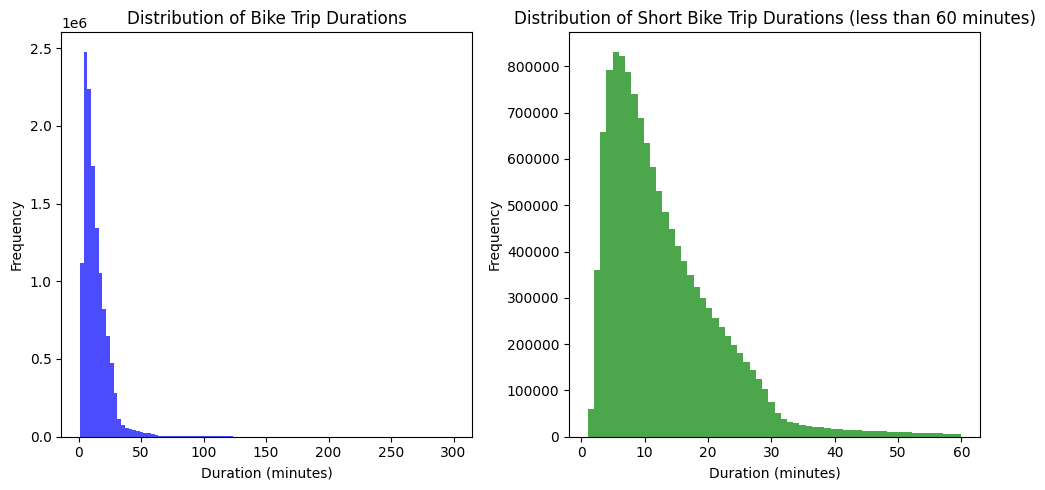

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(bike_df['Duration'], bins=100, color='blue', alpha=0.7)
ax[0].set_title('Distribution of Bike Trip Durations')
ax[0].set_xlabel('Duration (minutes)')
ax[0].set_ylabel('Frequency')
ax[1].hist(bike_df[bike_df['Duration'] < 60]['Duration'], bins=60, color='green', alpha=0.7)
ax[1].set_title('Distribution of Short Bike Trip Durations (less than 60 minutes)')
ax[1].set_xlabel('Duration (minutes)')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

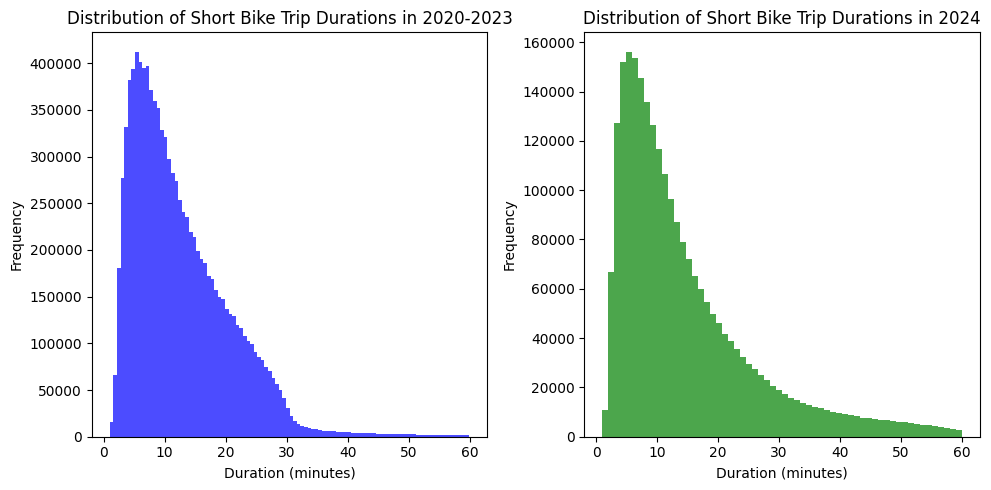

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(bike_df[(bike_df['Duration'] < 60) & (bike_df['Departure'].dt.year < 2024)]['Duration'], bins=100, color='blue', alpha=0.7)
ax[0].set_title('Distribution of Short Bike Trip Durations in 2020-2023')
ax[0].set_xlabel('Duration (minutes)')
ax[0].set_ylabel('Frequency')
ax[1].hist(bike_df[(bike_df['Duration'] < 60) & (bike_df['Departure'].dt.year == 2024)]['Duration'], bins=60, color='green', alpha=0.7)
ax[1].set_title('Distribution of Short Bike Trip Durations in 2024')
ax[1].set_xlabel('Duration (minutes)')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### EXLAIN THE DIFFERENCE PRE AND POST 2024 PRICING POLICY CHANGE

- 

In [17]:
pre_2024 = bike_df[bike_df['Departure'].dt.year < 2024]
post_2024 = bike_df[bike_df['Departure'].dt.year >= 2024]

print("Pre-2024 trips > 30 min percentage: ", round(len(pre_2024[pre_2024['Duration'] > 30]) / len(pre_2024), 3))
print("Post-2024 trips > 30 min percentage:", round(len(post_2024[post_2024['Duration'] > 30]) / len(post_2024), 3))

Pre-2024 trips > 30 min percentage:  0.033
Post-2024 trips > 30 min percentage: 0.117


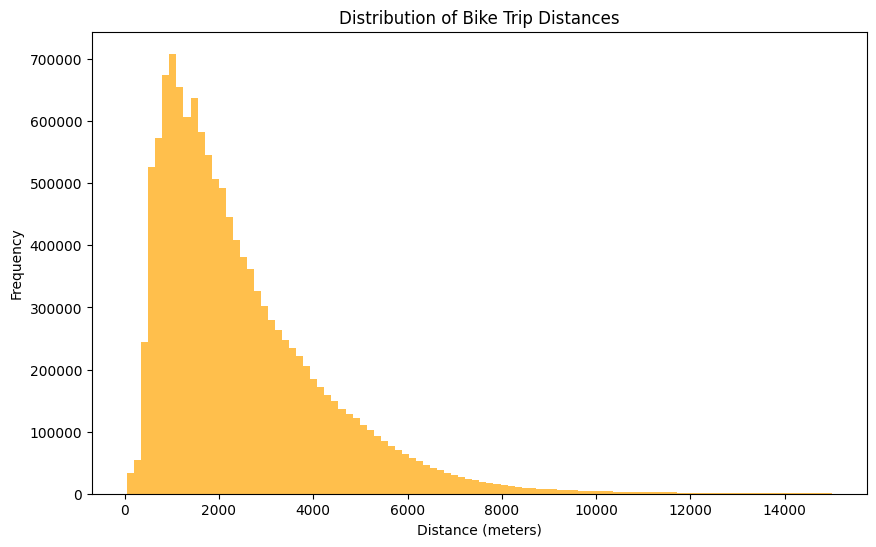

In [18]:
bike_df['Distance'].plot(kind='hist', bins=100, figsize=(10, 6), color='orange', alpha=0.7)
plt.title('Distribution of Bike Trip Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.show()

In [19]:
hourly_usage = bike_df.groupby([pd.Grouper(key='Departure', freq='h')]).size().reset_index(name='Count').set_index('Departure')

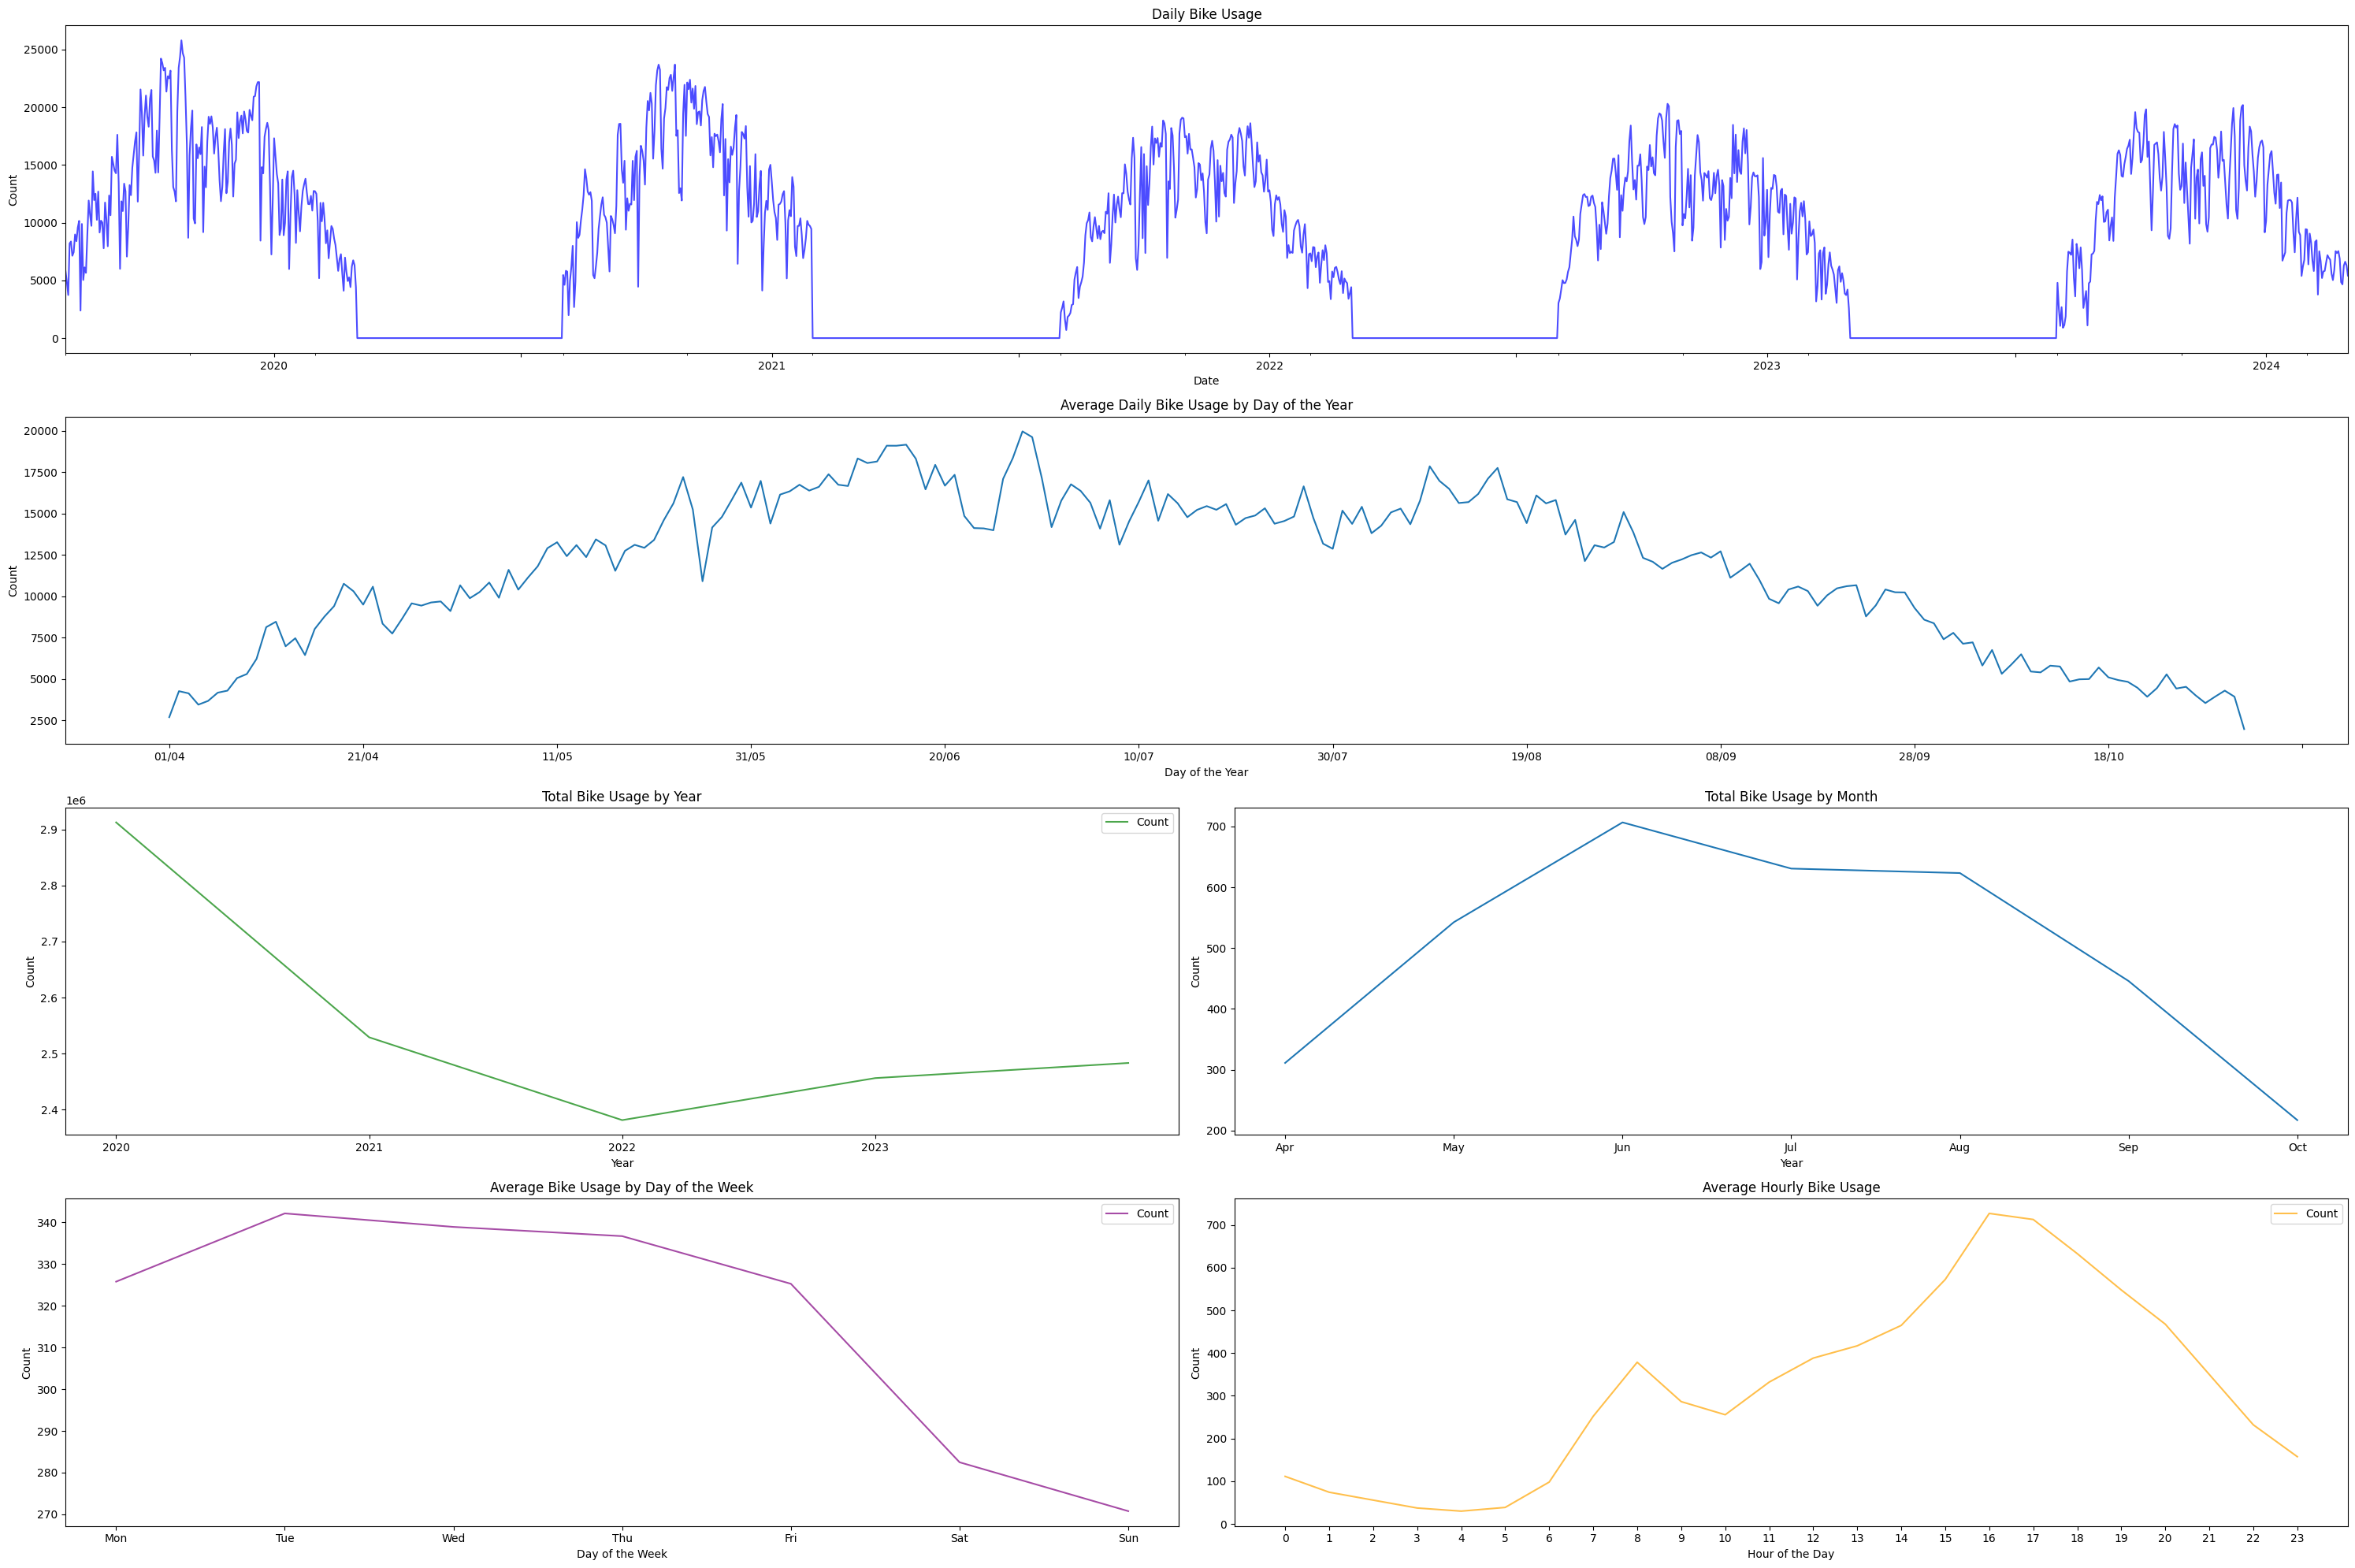

In [20]:
f, ax = plt.subplot_mosaic("AA;BB;CD;EF", figsize=(30,20))
df_daily = hourly_usage.resample('D').sum()
df_daily['Count'].plot(ax=ax['A'], color='blue', alpha=0.7)
ax["A"].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax["A"].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
[l.set_visible(False) for (i,l) in enumerate(ax["A"].xaxis.get_ticklabels()) if i % 2 != 0]
ax['A'].set_title('Daily Bike Usage')
ax['A'].set_xlabel('Date')
ax['A'].set_ylabel('Count')

day_of_year_mean = df_daily.groupby(df_daily.index.dayofyear).mean()
day_of_year_mean.index = pd.to_datetime(day_of_year_mean.index, format='%j').strftime('%d/%m')
ax['B'].plot(day_of_year_mean[day_of_year_mean['Count'] > 0])
ax["B"].xaxis.set_major_locator(plt.MaxNLocator(14))
ax['B'].set_title('Average Daily Bike Usage by Day of the Year')
ax['B'].set_xlabel('Day of the Year')
ax['B'].set_ylabel('Count')

hourly_usage.groupby([hourly_usage.index.year]).sum().plot(ax=ax['C'], color='green', alpha=0.7)
ax['C'].set_title('Total Bike Usage by Year')
ax["C"].set_xticks(np.arange(2020,2024))
ax['C'].set_xlabel('Year')
ax['C'].set_ylabel('Count')

monthly_mean = hourly_usage.groupby([hourly_usage.index.month]).mean()
monthly_mean.index = pd.to_datetime(monthly_mean.index, format='%m').strftime('%b')
ax['D'].plot(monthly_mean[monthly_mean['Count'] > 0])
ax['D'].set_title('Total Bike Usage by Month')
ax['D'].set_xlabel('Year')
ax['D'].set_ylabel('Count')

hourly_usage.groupby([hourly_usage.index.weekday]).mean().plot(ax=ax['E'], color='purple', alpha=0.7)
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax['E'].set_xticks(range(7))
ax['E'].set_xticklabels(weekdays)
ax['E'].xaxis.set_major_locator(plt.MaxNLocator(7))
ax['E'].set_title('Average Bike Usage by Day of the Week')
ax['E'].set_xlabel('Day of the Week')
ax['E'].set_ylabel('Count')

hourly_usage.groupby([hourly_usage.index.hour]).mean().plot(ax=ax['F'], color='orange', alpha=0.7)
ax["F"].set_xticks(np.arange(0,24))
ax['F'].set_title('Average Hourly Bike Usage')
ax['F'].set_xlabel('Hour of the Day')
ax['F'].set_ylabel('Count')


plt.tight_layout()
plt.show()

#### Analysis of the graphs (Maybe divide into separate graphs, could use radial plots for weekdays and hours)

- Day of the year ():
    - Try to explain peaks / valleys
        - Add holidays ? (Easter, midsummer etc)
        - seond half of May
        - Around misummer
        - ...
    - June vs July / August
- Yearly:
    - Most in 2020
    - Pretty constant 2021-2024
    - Least in 2022
- Monthly:
    - Most in June
    - Summer months Jun-Aug most rides
    - Spring more rides than autumn, Apr > Oct, May > Sept
- Weekdays:
    - More during the week than on weekends 
    - Tuesday most uses
    - Sunday least
- Hourly (Shows how many trips statr when the hour value is the graph value. Add separate plots for weekdays and weekends?): 
    - Peak at 8, work / school commute
    - Constant increase from 10 to 16
    - Most trips at 16 and 17, commute from work / school
    - Consistent during night, increase after 5
    - Concsistent deacrease after 17

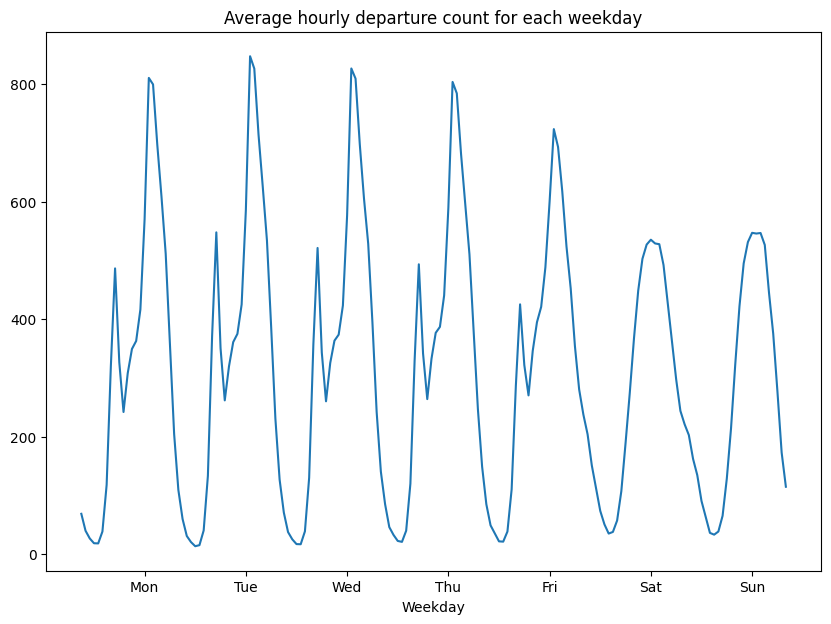

In [21]:
f, ax = plt.subplots(figsize=(10,7))
ax.plot(hourly_usage.groupby([hourly_usage.index.weekday, hourly_usage.index.hour])["Count"].mean().droplevel(1).values)
ax.set_xticks(np.arange(15, 168, 24))
ax.title.set_text('Average hourly departure count for each weekday')
ax.set_xlabel('Weekday')
ax.set_xticklabels(weekdays)

plt.show()

The daily trend is different between the weekdays and weekends. On weekdays the trend follows typical working hours, with a peak in the morning before the start of the workday and a larger and wider peak in the late afternoon and early evening after typical working hours. On weekends, the peak is wider but lower, with more balanced usage during the middle of the day.

In [22]:
station_df.head()

,name,lat,lon,capacity,source
ID,,,,,
150,Töölönlahden puisto,60.17,24.94,24,HSL
161,Eteläesplanadi,60.17,24.95,34,HSL
162,Leppäsuonaukio,60.17,24.93,28,HSL
163,Lehtisaarentie,60.18,24.85,12,HSL
118,Fleminginkatu,60.19,24.95,22,HSL


In [25]:
def merge_station_info(bike_df, station_df, station_type):
    hsl_stations = station_df[station_df['source'] == 'HSL']
    osm_stations = station_df[station_df['source'] == 'OSM']

    # Merge HSL station info
    bike_df = bike_df.merge(
        hsl_stations[['lat', 'lon', 'capacity']].add_prefix(f'{station_type}_'),
        left_on=f'{station_type}_id',
        right_index=True,
        how='left'
    )
    # Merge OSM station info as separate columns
    bike_df = bike_df.merge(
        osm_stations[['lat', 'lon', 'capacity', 'name']].add_prefix(f'OSM_{station_type}_'),
        left_on=f'{station_type}_name',
        right_on=f'OSM_{station_type}_name',
        how='left'
    )

    # Fill missing values from OSM
    for col in ['lat', 'lon', 'capacity']:
        bike_df[f'{station_type}_{col}'] = bike_df[f'{station_type}_{col}'].fillna(bike_df[f'OSM_{station_type}_{col}'])

    # Drop the OSM columns
    bike_df = bike_df.drop(columns=[
        f'OSM_{station_type}_name',
        f'OSM_{station_type}_lat',
        f'OSM_{station_type}_lon',
        f'OSM_{station_type}_capacity'
    ])

    return bike_df

In [26]:
bike_df = merge_station_info(bike_df, station_df, station_type='Departure')
bike_df = merge_station_info(bike_df, station_df, station_type='Return')

bike_df.head()


,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration,Departure_lat,Departure_lon,Departure_capacity,Return_lat,Return_lon,Return_capacity
0,2020-04-01 00:04:08,2020-04-01 00:21:27,062,Välimerenkatu,062,Välimerenkatu,999.00,17.30,60.16,24.92,16.00,60.16,24.92,16.00
1,2020-04-01 00:12:31,2020-04-01 00:21:34,149,Toinen linja,016,Liisanpuistikko,2372.00,8.97,60.18,24.94,22.00,60.17,24.96,17.00
2,2020-04-01 00:16:46,2020-04-01 00:46:09,118,Fleminginkatu,105,Tilkantori,4299.00,18.02,60.19,24.95,22.00,60.20,24.89,16.00
3,2020-04-01 00:19:29,2020-04-01 00:30:13,017,Varsapuistikko,013,Merisotilaantori,1923.00,10.65,60.17,24.95,28.00,60.17,24.98,24.00
4,2020-04-01 00:22:32,2020-04-01 00:27:29,030,Itämerentori,067,Perämiehenkatu,1376.00,4.87,60.16,24.91,40.00,60.16,24.93,16.00


In [80]:
departures = bike_df['Departure_name'].value_counts()
returns = bike_df['Return_name'].value_counts()

combined = pd.DataFrame({
    'Departures': departures,
    'Returns': returns
}).fillna(0).astype(int)

combined['Difference'] = combined['Departures'] - combined['Returns']
combined['Percentage Difference'] = (
    combined['Difference'] / combined[['Departures', 'Returns']].max(axis=1)
).round(3) * 100

combined_top = combined.sort_values(by='Departures', ascending=False).head(10)
combined_top

,Departures,Returns,Difference,Percentage Difference
Itämerentori,231682,233645,-1963,-0.80
Töölönlahdenkatu,176293,177064,-771,-0.40
Kalasatama (M),162125,168025,-5900,-3.50
Pasilan asema,160007,135310,24697,15.40
Ympyrätalo,145299,145847,-548,-0.40
Rautatientori / länsi,135993,138147,-2154,-1.60
Kamppi (M),123811,123095,716,0.60
Kanavaranta,119716,124273,-4557,-3.70
Rautatientori / itä,117893,119230,-1337,-1.10
"Aalto-yliopisto (M), Korkeakouluaukio",106347,105808,539,0.50


Top 10 stations in both departures and stations are the same, and with mostly similar order. The number of departures and returns in these stations are similar with 7 out of 10 stations having slightly more returns than departures. The biggest outlier in the list is 'Pasilan asema' where the number of departures is significanlty larger.

In [82]:
combined.sort_values(by='Difference', ascending=False).head(10)


,Departures,Returns,Difference,Percentage Difference
Pasilan asema,160007,135310,24697,15.40
Opastinsilta,29707,22699,7008,23.60
Karhupuisto,39402,34512,4890,12.40
Mäkelänkatu,35769,31116,4653,13.00
Hertanmäenkatu,29878,26019,3859,12.90
Vallilan varikko,24200,20490,3710,15.30
Leppäsuonaukio,53208,49939,3269,6.10
Kustaankatu,38467,35814,2653,6.90
Vallikatu,9290,6645,2645,28.50
Ilmalan asema,12727,10364,2363,18.60


In [83]:
combined.sort_values(by='Difference', ascending=True).head(10)

,Departures,Returns,Difference,Percentage Difference
Unioninkatu,71643,81158,-9515,-11.70
Hernesaarenranta,50165,57229,-7064,-12.30
Laajalahden aukio,58841,65001,-6160,-9.50
Kalasatama (M),162125,168025,-5900,-3.50
Kanavaranta,119716,124273,-4557,-3.70
Leppävaarankäytävä,38112,42404,-4292,-10.10
Arabian kauppakeskus,95874,100016,-4142,-4.10
Arabiankatu,53702,57322,-3620,-6.30
Kössi Koskisen aukio,27792,31154,-3362,-10.80
Kaivopuisto,79144,82499,-3355,-4.10


In [85]:
combined.sort_values(by='Percentage Difference', ascending=False).head(10)

,Departures,Returns,Difference,Percentage Difference
Workshop Helsinki,344,234,110,32.00
Vallikatu,9290,6645,2645,28.50
Opastinsilta,29707,22699,7008,23.60
Mestarinkatu,5020,3981,1039,20.70
Vallipolku,6696,5402,1294,19.30
Ilmalan asema,12727,10364,2363,18.60
Ruutikatu,4493,3662,831,18.50
Siilitie 13,6028,5066,962,16.00
Pasilan asema,160007,135310,24697,15.40
Vallilan varikko,24200,20490,3710,15.30


In [86]:
combined.sort_values(by='Percentage Difference', ascending=True).head(10)

,Departures,Returns,Difference,Percentage Difference
Jollas,3711,4703,-992,-21.10
Viikin normaalikoulu,19087,22173,-3086,-13.90
Haakoninlahdenkatu,6823,7866,-1043,-13.30
Rukatunturintie,3323,3830,-507,-13.20
Hauenkalliontie,10925,12530,-1605,-12.80
Olarinluoma,6480,7406,-926,-12.50
Vuosaaren liikuntapuisto,3058,3490,-432,-12.40
Agronominkatu,13368,15257,-1889,-12.40
Hernesaarenranta,50165,57229,-7064,-12.30
Unioninkatu,71643,81158,-9515,-11.70


In [60]:
top_pairs = bike_df.groupby(['Departure_name', 'Return_name']).size().sort_values(ascending=False).head(10)
top_pairs = pd.DataFrame(top_pairs).rename(columns={0: 'Number of trips'})
top_pairs.reset_index()

,Departure_name,Return_name,Number of trips
0,Jämeräntaival,"Aalto-yliopisto (M), Korkeakouluaukio",39642
1,"Aalto-yliopisto (M), Korkeakouluaukio",Jämeräntaival,39116
2,Arielinkatu,Sompasaari,16724
3,Tyynenmerenkatu,Itämerentori,13208
4,Itämerentori,Tyynenmerenkatu,13207
5,Itämerentori,Salmisaarenranta,13058
6,Matinkartanontie,Suomenlahdentie,12720
7,Länsisatamankuja,Itämerentori,12008
8,Itämerentori,Länsisatamankuja,11585
9,Salmisaarenranta,Itämerentori,11541


'Jämeräntaival' and 'Aalto-yliopisto (M), Korkeakouluaukio' pair is by far the most popular both ways. 6 ou the remaining 9 are also pairs where both ways appear, with 'Itämerentori' being part of all of these pairs. 

In [87]:
# Extract week and coordinates
bike_df['week'] = bike_df['Departure'].dt.to_period('W').apply(lambda r: r.start_time)

# Prepare departure data
dep = bike_df.groupby(['week', 'Departure_lat', 'Departure_lon']).size().reset_index(name='count')

# Prepare return data
ret = bike_df.groupby(['week', 'Return_lat', 'Return_lon']).size().reset_index(name='count')
ret.columns = ['week', 'lat', 'lon', 'count']
dep.columns = ['week', 'lat', 'lon', 'count']

# Combine
combined = pd.concat([dep, ret])
combined = combined.groupby(['week', 'lat', 'lon']).sum().reset_index()

import folium
from folium.plugins import TimestampedGeoJson

# Build features
features = []
for week, group in combined.groupby('week'):
    for _, row in group.iterrows():
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['lon'], row['lat']],
            },
            'properties': {
                'time': week.strftime('%Y-%m-%d'),
                'style': {'color': 'red'},
                'icon': 'circle',
                'popup': f"Count: {row['count']}",
                'radius': max(2, row['count'] ** 0.5 / 2)  # size by count
            }
        })

# Build map
m = folium.Map(location=[60.1699, 24.9384], zoom_start=12)
TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='P1W', add_last_point=True, auto_play=False, loop=False, max_speed=1).add_to(m)


In [97]:
# Step 1: Get top N most common routes
filtered_df = bike_df.dropna(subset=[
    'Departure_lat', 'Departure_lon',
    'Return_lat', 'Return_lon'
])
top_routes = (
    filtered_df.groupby(['Departure_id', 'Return_id'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(100)
)

# Step 2: Merge coordinates for start and end stations
station_coords = filtered_df[['Departure_id', 'Departure_name', 'Departure_lat', 'Departure_lon']].drop_duplicates()
station_coords = station_coords.rename(columns={'Departure_id': 'id', 'Departure_lat': 'lat', 'Departure_lon': 'lon'})

top_routes = top_routes.merge(station_coords, left_on='Departure_id', right_on='id')
top_routes = top_routes.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'}).drop(columns='id')

station_coords = filtered_df[['Return_id', 'Return_name', 'Return_lat', 'Return_lon']].drop_duplicates()
station_coords = station_coords.rename(columns={'Return_id': 'id', 'Return_lat': 'lat', 'Return_lon': 'lon'})

top_routes = top_routes.merge(station_coords, left_on='Return_id', right_on='id')
top_routes = top_routes.rename(columns={'lat': 'end_lat', 'lon': 'end_lon'}).drop(columns='id')

# Step 3: Plot routes on a map
m = folium.Map(location=[60.1699, 24.9384], zoom_start=12)

for _, row in top_routes.iterrows():
    folium.PolyLine(
        locations=[(row['start_lat'], row['start_lon']), (row['end_lat'], row['end_lon'])],
        weight=max(1, row['count'] / top_routes['count'].max() * 8),
        color='blue',
        opacity=0.6,
        tooltip=f"{row['count']} trips"
    ).add_to(m)

    # Add departure marker
    folium.CircleMarker(
        location=(row['start_lat'], row['start_lon']),
        radius=3,
        color='green',
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Departure: {row['Departure_name']}"
    ).add_to(m)

    # Add return marker
    folium.CircleMarker(
        location=(row['end_lat'], row['end_lon']),
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Return: {row['Return_name']}"
    ).add_to(m)

m